# Working with big data on the cloud

Processing steps:

Workflow for the cloud computing practical:
1. Search the ESA Copernicus Sentinel Data Hub for all available images over a region within a defined time period and low cloud cover
2. Download all selected images into a data directory
3. Convert all images into Geotiff files (retain only the 10 m resolution bands)
4. Save quicklooks of all images
5. Extract polygon statistics of NDVI as a time series from all data


In [1]:
# import all required Python packages:
# Note: GDAL needs to be version 2.1.3
# from Anaconda terminal type:
#    conda install -c conda-forge gdal

from collections import OrderedDict
import gdal
import json
import matplotlib.pyplot as plt
import numpy as np
import ogr
import os
from os import listdir
from os.path import isfile, isdir, join
import osr
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import shutil
from skimage import io, exposure
import subprocess
import sys
gdal.UseExceptions()
io.use_plugin('matplotlib')

Set up some directory names. Modify these to match your data directory structure.

In [2]:
# set up your directories for the satellite data
rootdir = join(os.sep, 'home', 'heiko', 'sf_GY7709_Satellite_Data_Analysis_in_Python', 'practicals')
# directory for downloading the Sentinel-2 granules
downloaddir = join(rootdir, 'download') 
# directory for the tiff files we will make
tiffdir = join(rootdir, 'tiff') 
# quicklook directory
quickdir = join(rootdir, 'quicklooks') 
# output directory for statistics file and search results
outdir = join(rootdir, 'outputs') 

# create the new directories, unless they already exist
os.makedirs(downloaddir, exist_ok=True)
os.makedirs(tiffdir, exist_ok=True)
os.makedirs(quickdir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)

Before proceeding, you have to make a text file called "sencredentials.txt" with your login details for the ESA Copernicus Sentinel Hub. The file has two lines of text.
Line 1: Your username
Line 2: Your password


In [3]:
# Download options and Data Hub search parameters
ndown = 10 # number of scenes to be downloaded (in order of least cloud cover)
shapefile = join(rootdir, 'p8area.shp') # ESRI Shapefile of the study area
datefrom = '20190401' # start date for imagery search
dateto   = '20190630' # end date for imagery search
clouds = '[0 TO 10]' # range of acceptable cloud cover % for imagery search
    # Note that later versions of the Sentinelsat package require this in the format: clouds = (0, 10) 
credentials = join(rootdir, 'sencredentials.txt')  # contains two lines of text with username and password

# Filename options
# VRT virtual raster stack of all image files
vrtfile = "mosaic.vrt"

Declare a function for converting all Sentinel-2 images in a directory into tiff files. Retain only the 10 m resolution bands.

In [4]:
# The next block of code is a function that reads in the Sentinel-2 L2A (Level 2A) image obtained 
#     from the Copernicus Sentinel Data Hub.
# It also changes the file to a new projection if defined
# Sentinel images can be obtained for free from this web site: https://scihub.copernicus.eu/dhus/#/home

def s2tiff(indir, outdir, ID, proj):
    '''
    indir = directory where the input files are located
    outdir = directory where the tiff file will be written if it does not already exist
    ID = a string giving the filename without file extension
    proj = output projection
    '''
    # list all files in input directory    
    print('Files in directory ' + indir)
    allfiles = [f for f in listdir(indir) if isfile(join(indir, f))]
    for f in allfiles:
        print(f)

    # make a band selection
    print('Band files to be included in tiff file:')    
    bands = allfiles[1:5]
    for b in bands:
        print(b)

    # build a command line command for GDAL to convert the files into 10 m resolution VRT format
    vrtfile = join(outdir, ID + '_16Bit.vrt')
    cmd = ['gdalbuildvrt', '-resolution', 'user', '-tr' ,'10', '10', '-separate', vrtfile]
    for band in bands:
        cmd.append(join(indir, band))

    if not os.path.exists(vrtfile): # skip if the output file already exists
        print('\n')
        print(' '.join(cmd))
        print('\n')
        subprocess.run(cmd) # execute the command in the command line
    else:
        print(vrtfile,' already exists.\n')
    
    # check whether the output directory already exists and create it if not
    os.makedirs(outdir, exist_ok=True)

    # define output file names
    tiffile = join(outdir, ID + '_16Bit.tif')
    projtiffile = join(outdir, ID + '_16Bit_proj.tif')

    if not os.path.exists(projtiffile): # skip if the output file already exists
        # build a command to translate the four band raster files into one geotiff file with 4 bands
        cmd = ['gdal_translate', '-of' ,'GTiff', vrtfile, tiffile]
        print(' '.join(cmd))
        print('\n')
        # execute the GDAL command
        subprocess.run(cmd) 

        # build a command to reproject the single Geotiff image to a new projection
        cmd = ['gdalwarp', tiffile, projtiffile, '-t_srs', proj]
        print(' '.join(cmd))
        print('\n')
        # execute the GDAL command
        subprocess.run(cmd) 

        os.remove(vrtfile) # delete the vrt file
        os.remove(tiffile) # delete the tiffile in the old projection

    else:
        print(projtiffile,' already exists.\n')


Declare a function for making one quicklook image in PNG format out of one or many TIFF files. The output file is smaller than the originals, i.e. not full resolution.


In [5]:
# This function makes one PNG quicklook file by mosaicking all tiff files in a list of filenames
# Note: the files must all the in the same projection

def quicklooks(tiffdir, infilelist, outdir, mosaicID, outsize):
    '''
    tiffdir = directory in which the files in infilelist are located
    infilelist = list of filenames (full path not included) to be processed
    outdir = directory where the PNG quicklook files will be saved
    mosaicID = beginning of the file name of the output files to be created (full path)
    outsize = percentage downscaling factor, e.g. 10 means 10% of xsize and 10% of ysize
    '''

    # make output filenames
    vrtfile = join(outdir, mosaicID + ".vrt")
    quicklookfile = join(outdir, mosaicID + ".png")

    print(vrtfile)
    print(quicklookfile)
    
    # save the list of file names to a text file for use in the GDAL command
    filelist = join(outdir, "filelist.txt") # make a file name
    
    print(filelist)

    file1 = open(filelist,"w") # open file in write mode 

    for f in infilelist:
        file1.write(join(tiffdir, f)) 
        file1.write("\n")
        print(join(tiffdir, f))
        print(os.path.exists(join(tiffdir, f)))
    file1.close() 

    # make a quicklook classification mosaic of all granules in PNG format using GDAL
    com = "gdalbuildvrt -overwrite -input_file_list " + filelist + " "+ vrtfile
    print(com)
    flag = os.system(com)
    if flag == 0:
        print('Created VRT file: ' + vrtfile)
    else:
        print('Error creating VRT file')

    # Create a PNG quicklook, scaled from 0 - 255
    com = "gdal_translate -of PNG -ot Byte -scale -outsize " + str(outsize) + "% " + \
        str(outsize) + "% " + vrtfile + " " + quicklookfile
    print(com)
    flag = os.system(com)
    if flag == 0:
        print('Created quicklook mosaic file: ' + quicklookfile)
    else:
        print('Error creating quicklook mosaic file')

#######################################################################
# MAIN SCRIPT
#######################################################################

In [6]:
#######################################################################
# 1. Search the ESA Copernicus Sentinel Data Hub for all available images 
#    over a region within a defined time period and low cloud cover
#######################################################################

os.chdir(rootdir) # go to working directory

# load user credentials for Sentinel Data Hub at ESA, i.e. read two lines of text with username and password
with open(credentials) as f:
    lines = f.readlines()
username = lines[0].strip()
password = lines[1].strip()
f.close()

# Define the API
api = SentinelAPI(username, password, 'https://scihub.copernicus.eu/dhus')

Convert the shapefile into GeoJSON if not already done.

In [7]:
# convert the shapefile to geojson as required by the Sentinel Hub
gjfile = shapefile.split(".")[0]+".geojson"

# check whether it exists already, e.g. from a previous run, in that case skip this step
if not os.path.exists(gjfile):
    com = "ogr2ogr -f GeoJSON -t_srs crs:84 " + gjfile + " " + shapefile
    flag = os.system(com)
    if flag == 0:
        print('Shapefile converted to Geojson format: ' + gjfile)
    else:
        print('Error converting shapefile to Geojson')
else:
    print('Geojson file already exists: ' + gjfile)

# convert the geojson to wkt for the API search on the Sentinel Hub
footprint = geojson_to_wkt(read_geojson(gjfile))

# get projection information from the shapefile to serve as output projection for the mosaic
driver = ogr.GetDriverByName('ESRI Shapefile')
shp = driver.Open(shapefile)
layer = shp.GetLayer()
outSpatialRef = layer.GetSpatialRef().ExportToWkt()
shp = None # close file

Geojson file already exists: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/p8area.geojson


Search the ESA Sentinel data hub.

In [8]:
# set query parameters and search the Sentinel data hub
query_kwargs = {
        'area': footprint,
        'date': (datefrom, dateto),
        'platformname': 'Sentinel-2',
        'processinglevel': 'Level-2A',
        'cloudcoverpercentage': clouds
        }

# search the Sentinel data hub API
products = api.query(**query_kwargs)

In [9]:
# convert list of products to Pandas DataFrame
products_df = api.to_dataframe(products)
print('Search resulted in '+str(products_df.shape[0])+' satellite images with '+
      str(products_df.shape[1])+' attributes.')

os.chdir(outdir) # set working direcory to directory for our text file outputs

# sort the search results
products_df_sorted = products_df.sort_values(['cloudcoverpercentage', 'ingestiondate'], ascending=[True, True])
print(products_df_sorted)
outfile = 'searchresults_full.csv'
products_df_sorted.to_csv(outfile)
print("Search results saved: " + outfile)

# limit to first Ndown products sorted by lowest cloud cover and earliest acquisition date
products_df_n = products_df_sorted.head(ndown)
outfile = 'searchresults4download.csv'
products_df_n.to_csv(outfile)
print("Download list saved: " + outfile)

# get the footprints of the selected scenes
s2footprints = products_df_n.footprint
outfile = 'searchresultsfootprints.csv'
s2footprints.to_csv(outfile, header = False)
print("Granule footprints saved: " + outfile)

Search resulted in 13 satellite images with 36 attributes.
                                                                                  title  \
9ac92e71-7bde-4290-9a47-6d2492e3169c  S2B_MSIL2A_20190524T105629_N0212_R094_T30UYE_2...   
e2543618-f3d1-42aa-ac9d-a7862bb5cfb1  S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_2...   
35dc5311-271f-4d7c-808f-8ff8cc30fd5c  S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_2...   
851a43ec-a2e6-4104-9da7-62bda5f930bd  S2A_MSIL2A_20190628T105621_N0212_R094_T30UXD_2...   
3661b627-0b92-4d4d-8691-33c294129443  S2B_MSIL2A_20190603T105629_N0212_R094_T30UYE_2...   
dd9a1c69-f127-4356-8004-7e3f5ae95095  S2B_MSIL2A_20190514T105629_N0212_R094_T30UXD_2...   
934a618c-cb64-4c50-b1a5-6ea5670bb0a2  S2B_MSIL2A_20190524T105629_N0212_R094_T31UCU_2...   
4b06d488-fb3a-487c-8db4-3e63058ad895  S2B_MSIL2A_20190514T105629_N0212_R094_T31UCU_2...   
f6814a1e-e092-4a0e-b865-4129f711f366  S2B_MSIL2A_20190524T105629_N0212_R094_T30UYD_2...   
0cc98e85-c1f4-4977-8b38-bb31f30

Download data. This takes a long time if many images are selected.

In [ ]:
#######################################################################
# 2. Download all selected images into a data directory
#######################################################################

os.chdir(downloaddir) # set working direcory to download directory

# download sorted and reduced products in order
api.download_all(products_df_n['uuid'])

In [10]:
# save the footprints of the scenes marked for download together with their metadata in a Geojson file
# first, run a new query to get the metadata for the selected scenes
products_n = OrderedDict()
for uuid in products_df_n['uuid']:
    kw = query_kwargs.copy()
    kw['uuid'] = uuid
    pp = api.query(**kw)
    products_n.update(pp)

# then, write the footprints and metadata to a geojson file
outfile = join(outdir, 'footprints.geojson')
with open(outfile, 'w') as f:
    json.dump(api.to_geojson(products_n), f)
print("Granule footprints saved as GeoJson: " + outfile)

Granule footprints saved as GeoJson: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/outputs/footprints.geojson


In [11]:
#######################################################################
# 3. Convert all images into reprojected Geotiff files (retain only the 10 m resolution bands)
#######################################################################

# set working direcory to download directory
os.chdir(downloaddir)

# get list of all zip files in the data directory
allfiles = [f for f in listdir(downloaddir) if isfile(join(downloaddir, f))]

# unzip all these files and convert the 10 m bands to Geotiff

for x in range(len(allfiles)):

    if allfiles[x].split(".")[1] == "zip":
        
        print("Unzipping file ", x+1, ": ", allfiles[x])
        os.system("unzip " + allfiles[x])

        # in this directory are the Sentinel-2, 10 m resolution band files
        
        # extract *.SAFE subdirectory path, then GRANULE, then L2A_*, then IMG_DATA, then R10m
        sceneID = allfiles[x].split(".")[0] # the first part of the directory name is the granule ID

        # find *.SAFE subdirectory
        dirlist = [d for d in listdir(downloaddir) if isdir(join(downloaddir, d))]
        for y in range(len(dirlist)):
            if dirlist[y].split(".")[1] == "SAFE":
                thisdir = join(downloaddir, dirlist[y])

        # find GRANULE subdirectory
        thisdir = join(thisdir, "GRANULE")

        # find L2A_* subdirectory
        dirlist = [d for d in listdir(thisdir) if isdir(join(thisdir, d))]
        for y in range(len(dirlist)):
            if dirlist[y].split("_")[0] == "L2A":
                thisdir = join(thisdir, dirlist[y])

        # find IMG_DATA subdirectory
        thisdir = join(thisdir, "IMG_DATA")

        # find R10m subdirectory
        thisdir = join(thisdir, "R10m")

        # call our function to convert the granule into a reprojected Geotiff file
        s2tiff(thisdir,tiffdir, sceneID, outSpatialRef)

Unzipping file  1 :  S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_20190512T122956.zip
Files in directory /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/download/S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135.SAFE/GRANULE/L2A_T30UXD_A012075_20190629T112256/IMG_DATA/R10m
T30UXD_20190629T112119_AOT_10m.jp2
T30UXD_20190629T112119_B02_10m.jp2
T30UXD_20190629T112119_B03_10m.jp2
T30UXD_20190629T112119_B04_10m.jp2
T30UXD_20190629T112119_B08_10m.jp2
T30UXD_20190629T112119_TCI_10m.jp2
T30UXD_20190629T112119_WVP_10m.jp2
Band files to be included in tiff file:
T30UXD_20190629T112119_B02_10m.jp2
T30UXD_20190629T112119_B03_10m.jp2
T30UXD_20190629T112119_B04_10m.jp2
T30UXD_20190629T112119_B08_10m.jp2
/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_20190512T122956_16Bit.vrt  already exists.

/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2A_MSIL2A_20190512T110621_N0212_R137_

gdalwarp /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190514T105629_N0212_R094_T30UYD_20190514T125218_16Bit.tif /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190514T105629_N0212_R094_T30UYD_20190514T125218_16Bit_proj.tif -t_srs GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]


Unzipping file  5 :  S2B_MSIL2A_20190514T105629_N0212_R094_T31UCU_20190514T125218.zip
Files in directory /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/download/S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135.SAFE/GRANULE/L2A_T30UXD_A012075_20190629T112256/IMG_DATA/R10m
T30UXD_20190629T112119_AOT_10m.jp2
T30UXD_20190629T112119_B02_10m.jp2
T30UXD_20190629T112119_B03_10m.jp2
T30UXD_20190629T112119_B0

gdalwarp /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190524T105629_N0212_R094_T30UYE_20190524T135557_16Bit.tif /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190524T105629_N0212_R094_T30UYE_20190524T135557_16Bit_proj.tif -t_srs GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]


Unzipping file  8 :  S2B_MSIL2A_20190524T105629_N0212_R094_T31UCU_20190524T135557.zip
Files in directory /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/download/S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135.SAFE/GRANULE/L2A_T30UXD_A012075_20190629T112256/IMG_DATA/R10m
T30UXD_20190629T112119_AOT_10m.jp2
T30UXD_20190629T112119_B02_10m.jp2
T30UXD_20190629T112119_B03_10m.jp2
T30UXD_20190629T112119_B0

gdalwarp /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit.tif /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif -t_srs GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]




In [12]:
#######################################################################
# 4. Save quicklooks of all image mosaics for each image acquisiton date
#######################################################################

# function to eliminate duplicate entries in a list by converting to a dictionary and back
def remove_duplicates(x):
    return list(dict.fromkeys(x))

# get list of all tiff files in the data directory
allfiles = [f for f in listdir(tiffdir) if (isfile(join(tiffdir, f)) and f.endswith('.tif'))]

print("\nAll files:")
print(allfiles)

# pull out all acquisition dates from the file names
# for the Sentinel-2 naming convention, see 
#     https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention
acqdates = remove_duplicates([f.split("_")[2].split("T")[0] for f in allfiles])

print("\nAll acquisition dates (sorted):")
print([f for f in sorted(acqdates)])

# go through all dates
for d in acqdates:
    
    # pull out all file names of the same acquisition date
    files2mosaic = [f for f in allfiles if (f.split("_")[2].split("T")[0] == d)]

    print("\nImages taken on date " + d)
    print(files2mosaic)
    
    # define a filename for the output file
    mosaicID = "S2_" + d

    # call our function
    quicklooks(tiffdir, files2mosaic, quickdir, mosaicID, 10)


All files:
['S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_20190512T122956_16Bit.tif', 'S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_20190512T122956_16Bit_proj.tif', 'S2A_MSIL2A_20190628T105621_N0212_R094_T30UXD_20190628T141522_16Bit_proj.tif', 'S2B_MSIL2A_20190514T105629_N0212_R094_T30UXD_20190514T125218_16Bit_proj.tif', 'S2B_MSIL2A_20190514T105629_N0212_R094_T30UYD_20190514T125218_16Bit_proj.tif', 'S2B_MSIL2A_20190514T105629_N0212_R094_T31UCU_20190514T125218_16Bit_proj.tif', 'S2B_MSIL2A_20190524T105629_N0212_R094_T30UYD_20190524T135557_16Bit_proj.tif', 'S2B_MSIL2A_20190524T105629_N0212_R094_T30UYE_20190524T135557_16Bit_proj.tif', 'S2B_MSIL2A_20190524T105629_N0212_R094_T31UCU_20190524T135557_16Bit_proj.tif', 'S2B_MSIL2A_20190603T105629_N0212_R094_T30UYE_20190603T140715_16Bit_proj.tif', 'S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif']

All acquisition dates (sorted):
['20190512', '20190514', '20190524', '20190603', '20190628', '20190629']

Images taken on 

Created quicklook mosaic file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/quicklooks/S2_20190603.png

Images taken on date 20190629
['S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif']
/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/quicklooks/S2_20190629.vrt
/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/quicklooks/S2_20190629.png
/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/quicklooks/filelist.txt
/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif
True
gdalbuildvrt -overwrite -input_file_list /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/quicklooks/filelist.txt /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/quicklooks/S2_20190629.vrt
Created VRT file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/quicklooks/S2_2019062

In [13]:
#######################################################################
# 5. Extract polygon statistics of NDVI as a time series from all data
#######################################################################

def tif2raster(tiffile):
    # read in a geotiff file (unsigned 16-bit integer format) and turn into a Python raster object
    img_ds = io.imread(tiffile)
    # convert to 16bit numpy array 
    img = np.array(img_ds, dtype='int16')
    return(img)

def zonal_stats(feat, input_zone_polygon, input_tiff, verbose = False, graphics = True, bands=[1,2,3]):
    '''
        extracts statistics from a feature (polygon) of a shapefile from a tiff file with several bands
        heavily adapted from:
        https://gis.stackexchange.com/questions/208441/zonal-statistics-of-a-polygon-and-assigning-mean-value-to-the-polygon
    '''

    if verbose:
        print("--------------------------------------------------------------------")
        print("Processing raster file: " + input_tiff)
        
    # Open vector data
    shp = ogr.Open(input_zone_polygon)
    lyr = shp.GetLayer()

    # Get raster georeference info
    dataset = gdal.Open(input_tiff, gdal.GA_ReadOnly)
    if not dataset:
        print("Error. Tiff file not found: " + input_tiff)

    ncols = dataset.RasterXSize
    nrows = dataset.RasterYSize
    nbands = dataset.RasterCount
    wkt_projection = dataset.GetProjection()

    if verbose:
        print("Raster size: {} x {} x {}".format(ncols, nrows, nbands))
        print("Raster projection: {}".format(wkt_projection))

    geotransform = dataset.GetGeoTransform()
    if geotransform:
        xOrigin = geotransform[0]
        yOrigin = geotransform[3]
        pixelWidth = geotransform[1]
        pixelHeight = geotransform[5]
        if verbose:
            print("Tiff file image origin xmin,yax = ({}, {})".format(geotransform[0], geotransform[3]))
            print("Pixel Size x,y = ({}, {})".format(geotransform[1], geotransform[5]))
    else:
        print("Error. Geotransform not found in tiff file: " + input_tiff) 

    # Reproject vector geometry to same projection as raster
    sourceSR = lyr.GetSpatialRef()
    targetSR = osr.SpatialReference()
    targetSR.ImportFromWkt(wkt_projection)
    coordTrans = osr.CoordinateTransformation(sourceSR,targetSR)
    feat = lyr.GetNextFeature()
    geom = feat.GetGeometryRef()
    geom.Transform(coordTrans)

    # Get extent of the feature for which to extract the raster statistics
    geom = feat.GetGeometryRef()
    if (geom.GetGeometryName() == 'MULTIPOLYGON'):
        count = 0
        pointsX = []; pointsY = []
        for polygon in geom:
            geomInner = geom.GetGeometryRef(count)
            ring = geomInner.GetGeometryRef(0)
            numpoints = ring.GetPointCount()
            for p in range(numpoints):
                    lon, lat, z = ring.GetPoint(p)
                    pointsX.append(lon)
                    pointsY.append(lat)
            count += 1
    elif (geom.GetGeometryName() == 'POLYGON'):
        ring = geom.GetGeometryRef(0)
        numpoints = ring.GetPointCount()
        pointsX = []; pointsY = []
        for p in range(numpoints):
                lon, lat, z = ring.GetPoint(p)
                pointsX.append(lon)
                pointsY.append(lat)

    else:
        sys.exit("ERROR: Geometry needs to be either Polygon or Multipolygon")

    # extent of this feature in map coordinates
    xmin = min(pointsX)
    xmax = max(pointsX)
    ymin = min(pointsY)
    ymax = max(pointsY)

    if verbose:
        print("\nFeature extent in map coordinates: xmin,xmax, ymin, ymax", xmin, xmax, ymin, ymax)
       
    # raster layer extent in map coordinates
    xmin1 = xOrigin
    xmax1 = xOrigin + ncols * pixelWidth
    ymin1 = yOrigin + nrows * pixelHeight
    ymax1 = yOrigin

    if verbose:
        print("\nGeotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1")
        print(xmin1,xmax1,ymin1,ymax1)
    
    # extent of the intersect between the featurs / polygon / zone and the raster image in map coordinates
    xmin2 = max(xmin,xmin1)
    xmax2 = min(xmax,xmax1)
    ymin2 = max(ymin,ymin1)
    ymax2 = min(ymax,ymax1)

    if verbose:
        print("\nIntersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2")
        print(xmin2,xmax2,ymin2,ymax2)
    
    # clip the Geotiff raster layer to the extent of the intersect with the feature
    xoff = int((xmin2 - xOrigin)/pixelWidth)
    yoff = int((yOrigin - ymax2)/pixelWidth)
    xcount = int((xmax2 - xmin2)/pixelWidth)
    ycount = int((ymax2 - ymin2)/pixelWidth)

    if verbose:
        print("\nclipped raster layer extent in pixels: xoff, yoff, xcount, ycount")
        print("xoff = ", xoff)
        print("yoff = ", yoff)
        print("xcount = ", xcount)
        print("ycount = ", ycount)

    # clip the rasterised feature layer to the extent of the intersect with the feature
    xoff1 = int((xmin2 - xmin)/pixelWidth)
    yoff1 = int((ymax - ymax2)/pixelWidth)
    xcount1 = int((xmax2 - xmin2)/pixelWidth)
    ycount1 = int((ymax2 - ymin2)/pixelWidth)

    if verbose:
        print("\nclipped feature layer extent in pixels: xoff1,yoff1,xcount1,ycount1")
        print("xoff1 = ", xoff1)
        print("yoff1 = ", yoff1)
        print("xcount1 = ", xcount1)
        print("ycount1 = ", ycount1)

    # Create memory target raster for the mask with all pixels within the feature (zone)
    target_ds = gdal.GetDriverByName('MEM').Create('', xcount, ycount, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform((xmin2, pixelWidth, 0, ymax2, 0, pixelHeight,))

    # make projection the same as for the Geotiff Sentinel-2 raster file
    target_ds.SetProjection(wkt_projection)

    # create an empty array to hold the statistics results for all bands
    stats = np.zeros((nbands, 7))

    # plot a colour composite of three bands
    if graphics:
        # create an empty array to hold the 3 stretched colour bands
        img = np.zeros((ycount, xcount, 3), dtype = np.int16)
        for band in range(0, 3):
            # Read intersecting Geotiff raster layer values as an array
            thisband = np.array(dataset.GetRasterBand(bands[band]).ReadAsArray(xoff, yoff, xcount, ycount)).astype(np.float)
            # Contrast stretching and byte scaling
            p2, p98 = np.percentile(thisband, (2, 98))
            img[:, :, band] = np.int16(exposure.rescale_intensity(thisband, in_range=(p2, p98)) * 255)
        plt.figure().suptitle("Colour composite")
        io.imshow(img)
        io.show()
        img = None # free up memory
        thisband = None

    # Rasterize the feature (zone polygon) to the target raster layer
    #   burn_value of 1 indicates that a pixels is within the feature (zone)
    gdal.RasterizeLayer(target_ds, [1], lyr, burn_values=[1]) #, ['ALL_TOUCHED=TRUE']

    if verbose:
        print("Zone mask raster size: ", target_ds.GetRasterBand(1).ReadAsArray().shape)
        print("Zone mask raster min,max: ", np.nanmin(target_ds.GetRasterBand(1).ReadAsArray()), np.nanmax(target_ds.GetRasterBand(1).ReadAsArray()))

    if graphics:
        # Display the whole rasterised zone mask
        plt.figure().suptitle("Zone mask")
        io.imshow(np.array(target_ds.GetRasterBand(1).ReadAsArray()), cmap='gray_r')

    # loop over all bands
    for band in range(1, nbands + 1):
        
        if verbose:
            print("\nBand ", band)
        
        # Read intersecting Geotiff raster layer values as an array
        dataraster = np.array(dataset.GetRasterBand(band).ReadAsArray(xoff, yoff, xcount, ycount)).astype(np.float)

        # clip the rasterised feature layer to the extent of the intersect with the geotiff raster layer
        datamask = target_ds.GetRasterBand(1).ReadAsArray().astype(np.byte)

        # do something here to catch situations where dataraster is all NaNs
        #    replace 1 in datamask with 0 where NaNs are found in dataraster
        datamask[np.isnan(dataraster)] = 0

        warnme = 0 # no warnings so far

        if (np.nanmin(dataraster) == np.nan and np.nanmax(dataraster) == np.nan):
            print("WARNING: All dataraster values are NaN.")
            warnme = warnme + 1
        else:
            if (dataraster.shape == ()):
                print("WARNING: Failed to create dataraster.")
                warnme = warnme + 1
            else:
                if verbose:
                    print("Data raster min, max: ", np.nanmin(dataraster), np.nanmax(dataraster))
                            
                if (np.min(datamask) == 0 and np.max(datamask) == 0):
                    print("WARNING: All datamask values are zero.")
                    warnme = warnme + 1
                else:
                    if verbose:
                        print("Data mask min, max: ", np.min(datamask), np.max(datamask))
                    
                    # Apply the mask from the rasterised feature layer (zone polygon) to the Geotiff raster
                    zoneraster = np.ma.MaskedArray(dataraster, datamask)
                    dataraster = None # free up memory
                    datamask = None
                    
                    if (np.min(zoneraster) == 0 and np.max(zoneraster) == 0):
                        print("WARNING: All zoneraster values are zero.")
                        warnme = warnme + 1
                    else:
                        if verbose:
                            print("Zone raster min, max: ", np.min(zoneraster.data), np.max(zoneraster.data))
                
                        if graphics:
                            p2, p98 = np.percentile(zoneraster, (2, 98))
                            img = exposure.rescale_intensity(zoneraster, in_range=(p2, p98)) # Contrast stretching
                            plt.figure().suptitle("Zone raster")
                            io.imshow(img, cmap='gray_r')

        if graphics:
            io.show()

        # calculate band statistics under the zone mask
        # N.B. The -1 is there to get Python indices from 0...3 from the band variable 1...4 (see for loop)
        stats[band - 1, 0] = band
        stats[band - 1, 1] = np.ma.average(zoneraster)
        stats[band - 1, 2] = np.ma.mean(zoneraster)
        stats[band - 1, 3] = np.ma.median(zoneraster)
        stats[band - 1, 4] = np.ma.std(zoneraster)
        stats[band - 1, 5] = np.ma.var(zoneraster)
        stats[band - 1, 6] = np.ma.sum(zoneraster)       
        
    # close files
    dataset = None
    shp = None
    
    # free up memory
    target_ds = None

    if (warnme > 0):
        print(warnme, " WARNINGS issued. Returning zero values from the zone statistics function.")

    return stats


def loop_zonal_stats(input_zone_polygon, input_tiff, verbose = False, graphics = False, bands = [1,2,3]):

    shp = ogr.Open(input_zone_polygon)
    lyr = shp.GetLayer()
    featList = range(lyr.GetFeatureCount())
    statDict = {}

    for FID in featList:
        if verbose:
            print("Feature ID: ", FID)
        feat = lyr.GetFeature(FID)
        meanValue = zonal_stats(feat, input_zone_polygon, input_tiff, verbose, graphics)
        statDict[FID] = meanValue
    return statDict


All tile IDs (sorted):
T30UXD
T30UYD
T30UYE
T31UCU



Image files acquired for tile T30UXD
S2A_MSIL2A_20190628T105621_N0212_R094_T30UXD_20190628T141522_16Bit_proj.tif
S2B_MSIL2A_20190514T105629_N0212_R094_T30UXD_20190514T125218_16Bit_proj.tif
S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif

Acquisition dates for this tile (sorted):
['20190514', '20190628', '20190629']

Saving tile statistics to file:  /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/outputs/S2_T30UXD.txt
Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2A_MSIL2A_20190628T105621_N0212_R094_T30UXD_20190628T141522_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.017453292

/home/heiko/anaconda3/envs/pyeo_env/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


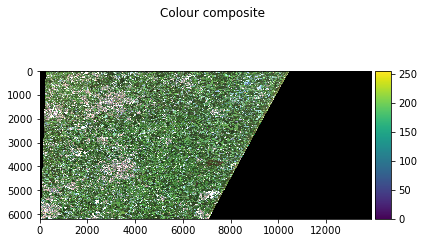

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


/home/heiko/anaconda3/envs/pyeo_env/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


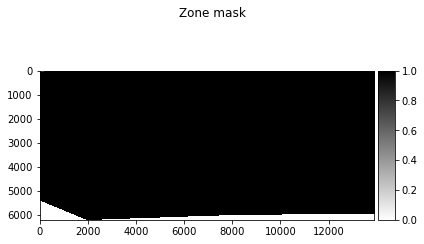

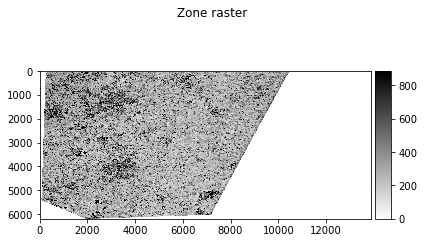


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


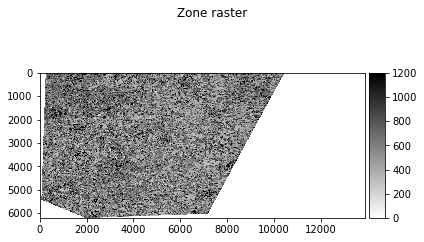


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


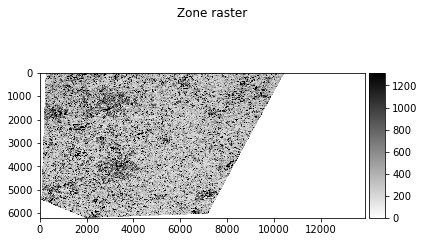


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


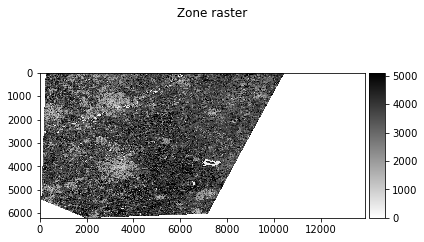

Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190514T105629_N0212_R094_T30UXD_20190514T125218_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.0001206629706528257, -0.0001206629706528257)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -1.692236082313751 0.3648677608530213 52.37229407530868 53.11974361034032

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.5350196328445165 0.14171300734714953 52.222536854504206 53.24020834899014

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-1.5

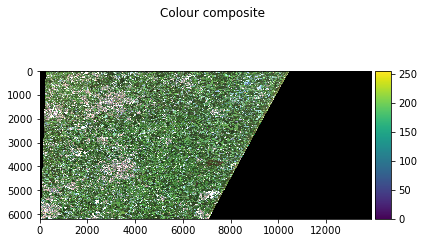

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


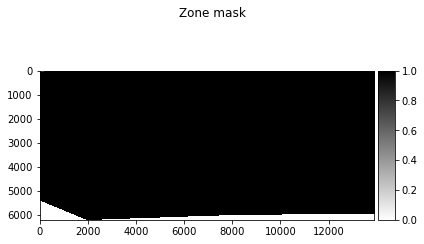

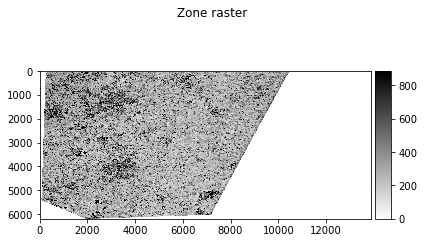


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


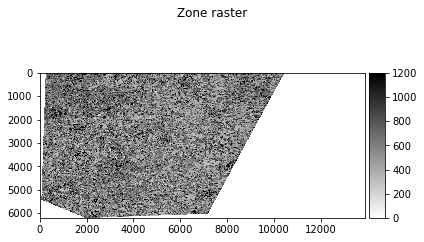


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


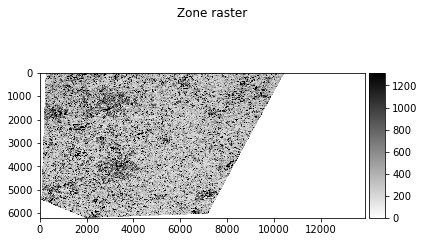


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


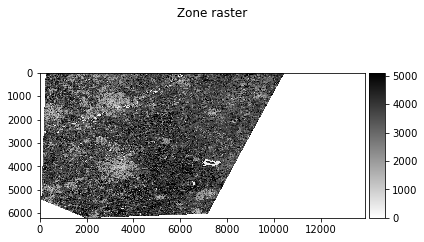

Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.0001206629706528257, -0.0001206629706528257)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -1.692236082313751 0.3648677608530213 52.37229407530868 53.11974361034032

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.5350196328445165 0.14171300734714953 52.222536854504206 53.24020834899014

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-1.5

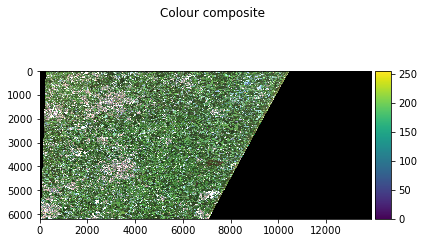

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


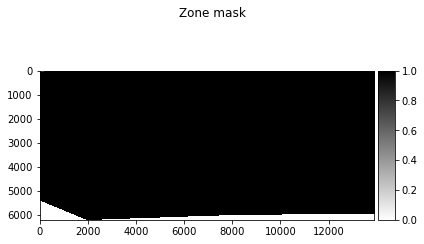

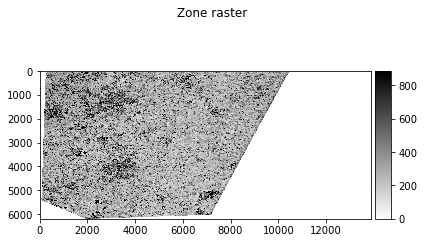


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


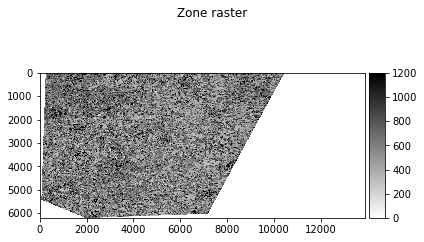


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


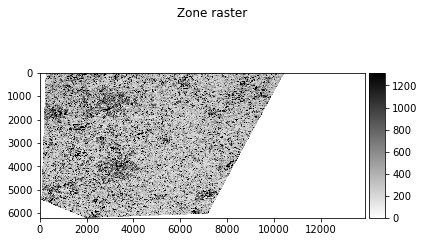


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


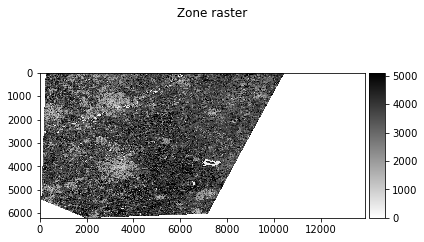


Image files acquired for tile T30UYD
S2B_MSIL2A_20190514T105629_N0212_R094_T30UYD_20190514T125218_16Bit_proj.tif
S2B_MSIL2A_20190524T105629_N0212_R094_T30UYD_20190524T135557_16Bit_proj.tif

Acquisition dates for this tile (sorted):
['20190514', '20190524']

Saving tile statistics to file:  /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/outputs/S2_T30UYD.txt
Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190514T105629_N0212_R094_T30UYD_20190514T125218_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.000120662970

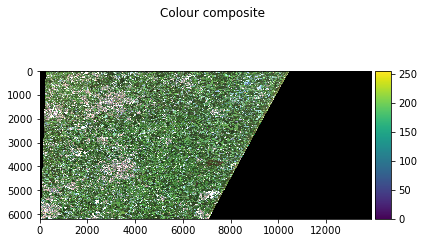

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


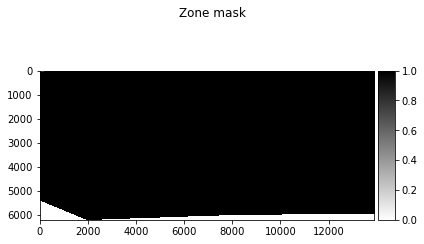

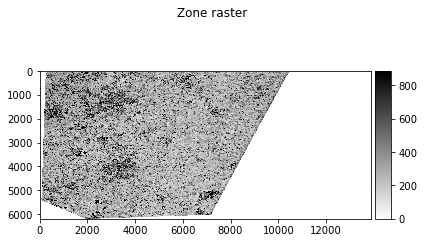


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


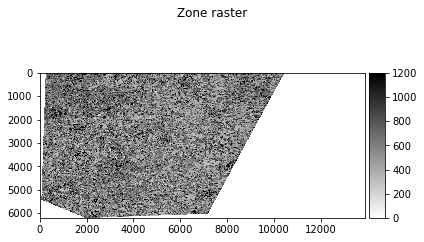


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


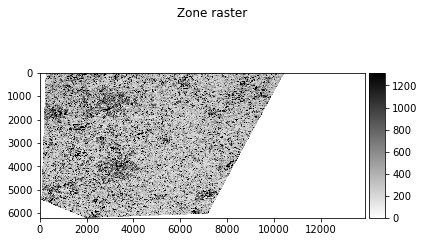


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


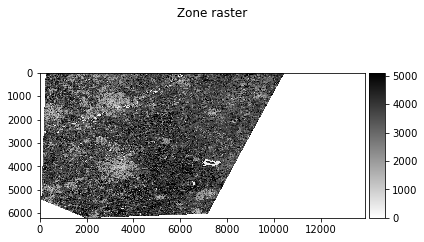

Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190524T105629_N0212_R094_T30UYD_20190524T135557_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.0001206629706528257, -0.0001206629706528257)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -1.692236082313751 0.3648677608530213 52.37229407530868 53.11974361034032

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.5350196328445165 0.14171300734714953 52.222536854504206 53.24020834899014

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-1.5

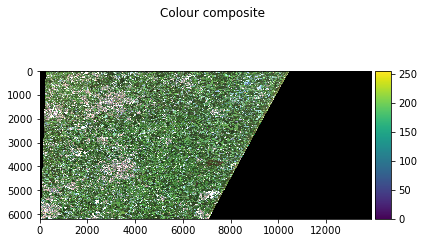

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


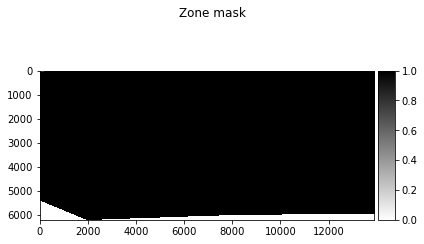

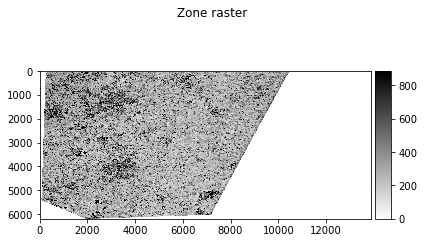


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


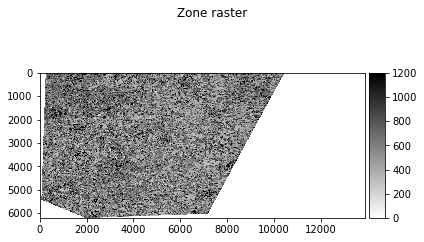


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


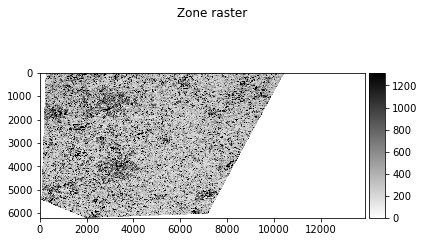


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


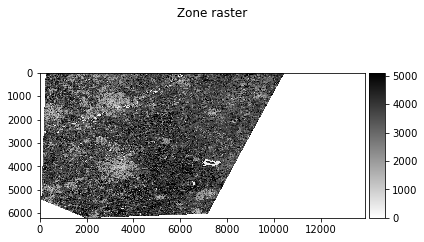


Image files acquired for tile T30UYE
S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_20190512T122956_16Bit.tif
S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_20190512T122956_16Bit_proj.tif
S2B_MSIL2A_20190524T105629_N0212_R094_T30UYE_20190524T135557_16Bit_proj.tif
S2B_MSIL2A_20190603T105629_N0212_R094_T30UYE_20190603T140715_16Bit_proj.tif

Acquisition dates for this tile (sorted):
['20190512', '20190524', '20190603']

Saving tile statistics to file:  /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/outputs/S2_T30UYE.txt
Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_20190512T122956_16Bit.tif
Raster size: 10980 x 10980 x 4
Raster projection: PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRI

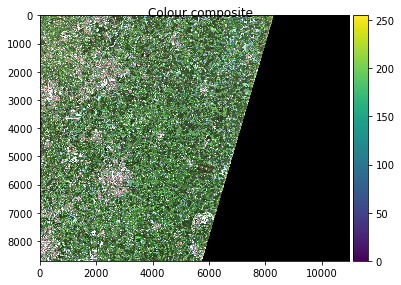

Zone mask raster size:  (8701, 10980)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


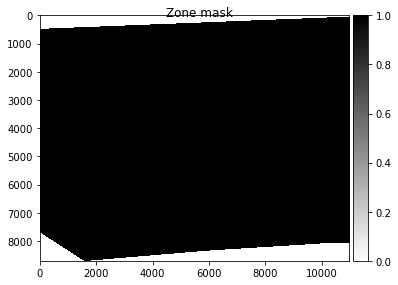

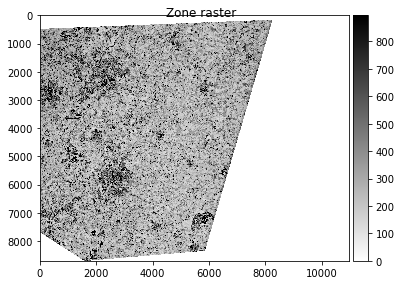


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


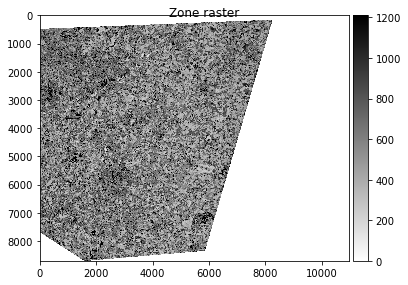


Band  3
Data raster min, max:  0.0 17936.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17936.0


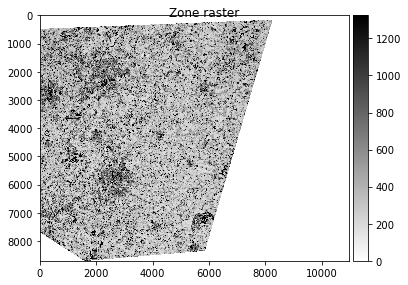


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


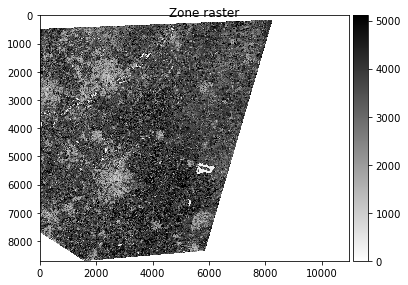

Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2A_MSIL2A_20190512T110621_N0212_R137_T30UYE_20190512T122956_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.0001206629706528257, -0.0001206629706528257)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -1.692236082313751 0.3648677608530213 52.37229407530868 53.11974361034032

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.5350196328445165 0.14171300734714953 52.222536854504206 53.24020834899014

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-1.5

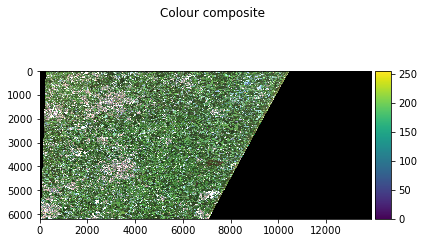

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


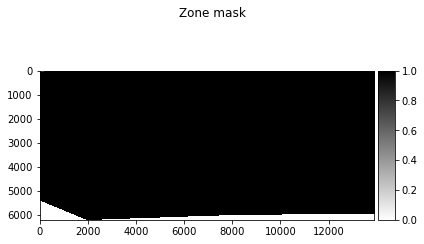

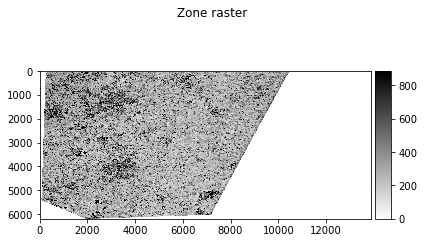


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


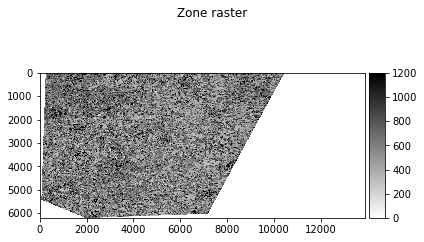


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


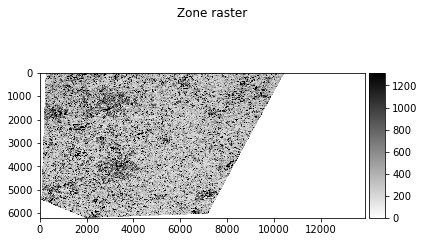


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


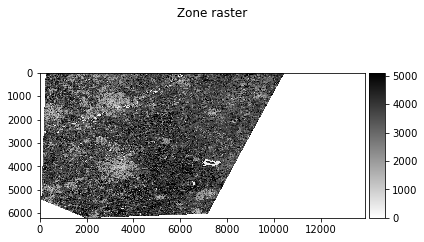

Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190524T105629_N0212_R094_T30UYE_20190524T135557_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.0001206629706528257, -0.0001206629706528257)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -1.692236082313751 0.3648677608530213 52.37229407530868 53.11974361034032

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.5350196328445165 0.14171300734714953 52.222536854504206 53.24020834899014

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-1.5

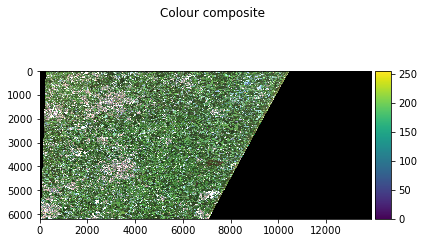

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


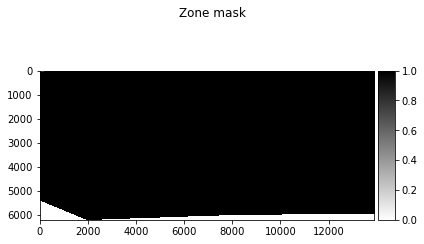

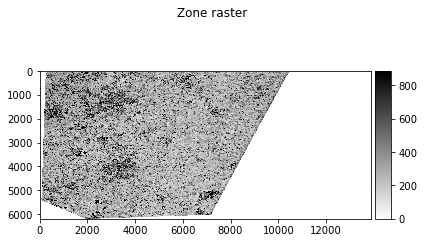


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


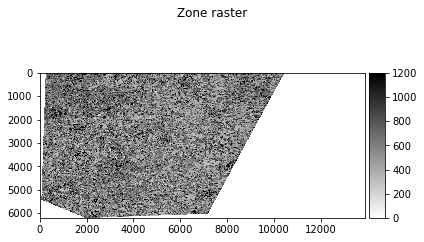


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


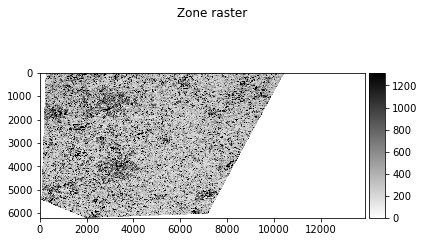


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


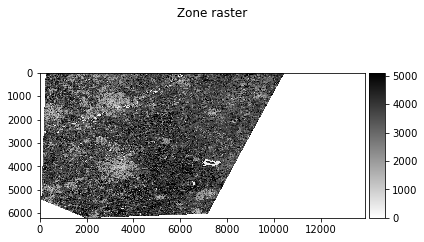

Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190603T105629_N0212_R094_T30UYE_20190603T140715_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.0001206629706528257, -0.0001206629706528257)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -1.692236082313751 0.3648677608530213 52.37229407530868 53.11974361034032

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.5350196328445165 0.14171300734714953 52.222536854504206 53.24020834899014

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-1.5

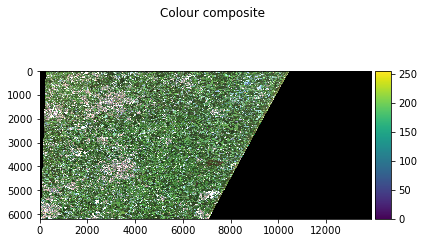

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


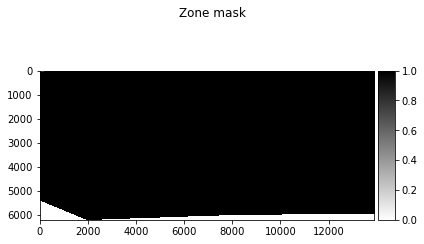

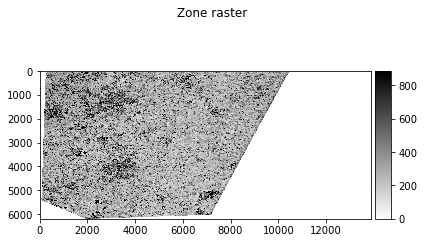


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


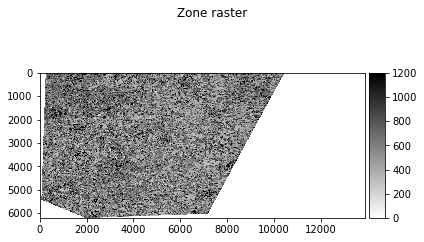


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


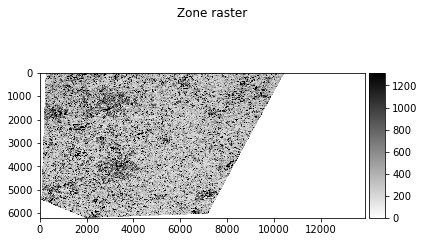


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


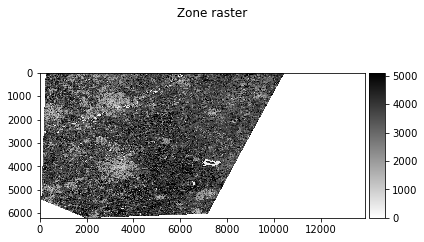


Image files acquired for tile T31UCU
S2B_MSIL2A_20190514T105629_N0212_R094_T31UCU_20190514T125218_16Bit_proj.tif
S2B_MSIL2A_20190524T105629_N0212_R094_T31UCU_20190524T135557_16Bit_proj.tif

Acquisition dates for this tile (sorted):
['20190514', '20190524']

Saving tile statistics to file:  /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/outputs/S2_T31UCU.txt
Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190514T105629_N0212_R094_T31UCU_20190514T125218_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.000120662970

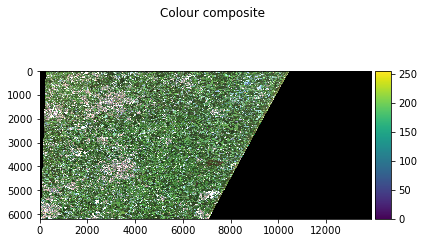

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


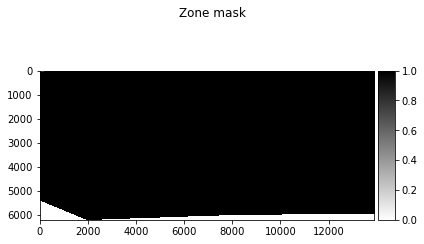

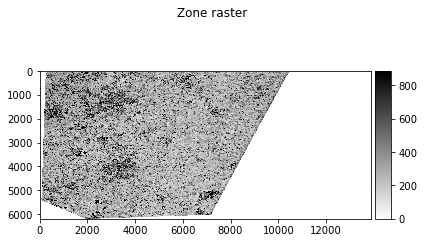


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


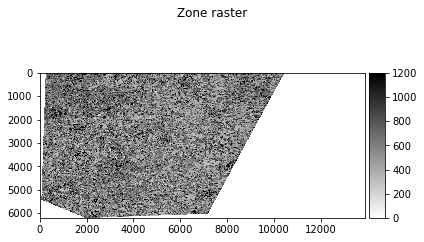


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


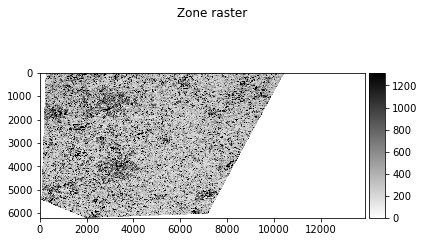


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


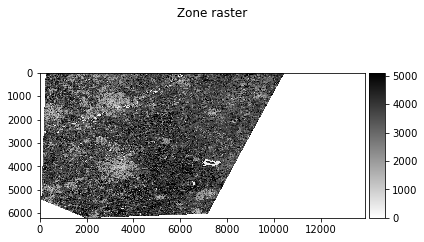

Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/tiff/S2B_MSIL2A_20190524T105629_N0212_R094_T31UCU_20190524T135557_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.5350196328445165, 53.24020834899014)
Pixel Size x,y = (0.0001206629706528257, -0.0001206629706528257)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -1.692236082313751 0.3648677608530213 52.37229407530868 53.11974361034032

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.5350196328445165 0.14171300734714953 52.222536854504206 53.24020834899014

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-1.5

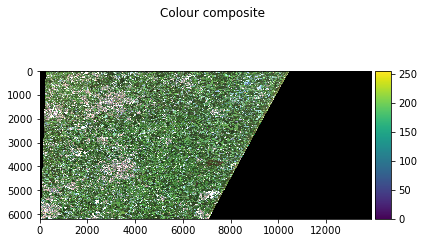

Zone mask raster size:  (6194, 13896)
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  0.0 20512.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 20512.0


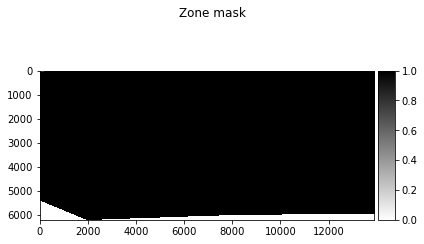

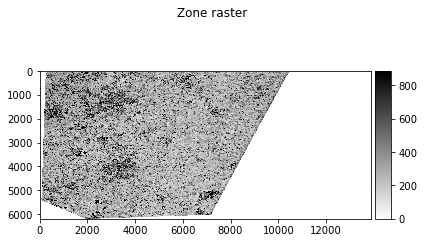


Band  2
Data raster min, max:  0.0 18976.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 18976.0


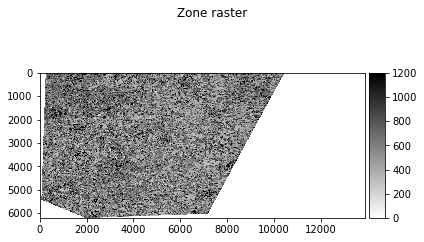


Band  3
Data raster min, max:  0.0 17888.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 17888.0


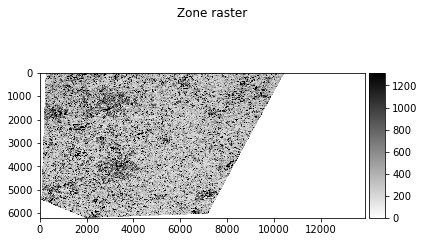


Band  4
Data raster min, max:  0.0 16608.0
Data mask min, max:  0 1
Zone raster min, max:  0.0 16608.0


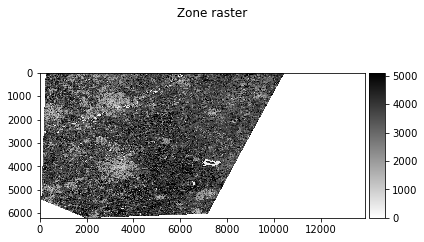

In [14]:
# pull out all tile IDs from the file names
# the tiling grid can be downloaded from here as a .kml file:
#     https://sentinel.esa.int/web/sentinel/missions/sentinel-2/data-products
tiles = sorted(remove_duplicates([f.split("_")[5] for f in allfiles]))

print("\nAll tile IDs (sorted):")
for t in tiles:
    print(t)
print("\n") # new line

# check whether shapefile exists
if not os.path.exists(shapefile):
    print('Shapefile not found: ' + shapefile)
else:
    # go through all tiles and extract statistics for all available acquisition dates for that tile
    
    for t in tiles:

        # get all file names with the same tile ID from the list of all tiff files
        filestack = [f for f in allfiles if (f.split("_")[5] == t)]
        print("\nImage files acquired for tile " + t)
        for xfile in filestack:
            print(xfile)

        # pull out all acquisition dates from the file names
        acqdates = remove_duplicates([f.split("_")[2].split("T")[0] for f in filestack])
        print("\nAcquisition dates for this tile (sorted):")
        print([f for f in sorted(acqdates)])
        
        # define a filename for the output text file with the statistics
        timeseries = join(outdir, "S2_" + t + ".txt")
        print("\nSaving tile statistics to file: ", timeseries)
        outfile = open(timeseries, "w")

        # write header line
        outfile.write("AcqDate, Zone, Band, Average, Mean, Median, Std_Deviation, Variance, N_Pixels\n")

        # for each acquisition date, get the polygon statistics of that tile
        for xfile in filestack:

            # get acquisition date for that file
            acqdate = xfile.split("_")[2].split("T")[0]

            # run the loop over all polygons (zones) and all image files
            # the bands here will be shown as RGB if graphics is True
            result_dict = loop_zonal_stats(shapefile, join(tiffdir, xfile), verbose = True, graphics = True, bands=[1,2,3])

            # save acquisition dates and statistics of that tile to the statistics file
            # for each zone (polygon ID) in the results dictionary, there is an array with the statistics for each band
            for zone, stat in result_dict.items():
                for band in range(stat.shape[0]):
                    outfile.write(acqdate + ', ' + str(zone) + ', ')
                    this_line = list(stat[band, ]) # line of statistics for output file
                    for item in this_line:
                        if item == this_line[0]: # first item in the line
                            outfile.write("%s, " % np.int32(item))
                        else:
                            if item == this_line[len(this_line) - 1]:  # last item in the line
                                outfile.write("%s\n" % item)
                            else:
                                outfile.write("%s, " % item) # all other items in the line

        outfile.close()
    